<a href="https://colab.research.google.com/github/Kushal-LTI/Blood-cancer-detection/blob/main/Resnet50_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import kagglehub
sumithsingh_blood_cell_images_for_cancer_detection_path = kagglehub.dataset_download('sumithsingh/blood-cell-images-for-cancer-detection')

print('Data source import complete.')

Using Colab cache for faster access to the 'blood-cell-images-for-cancer-detection' dataset.
Data source import complete.


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [12]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


# <h1 style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Target Classes</span></b> </h1>

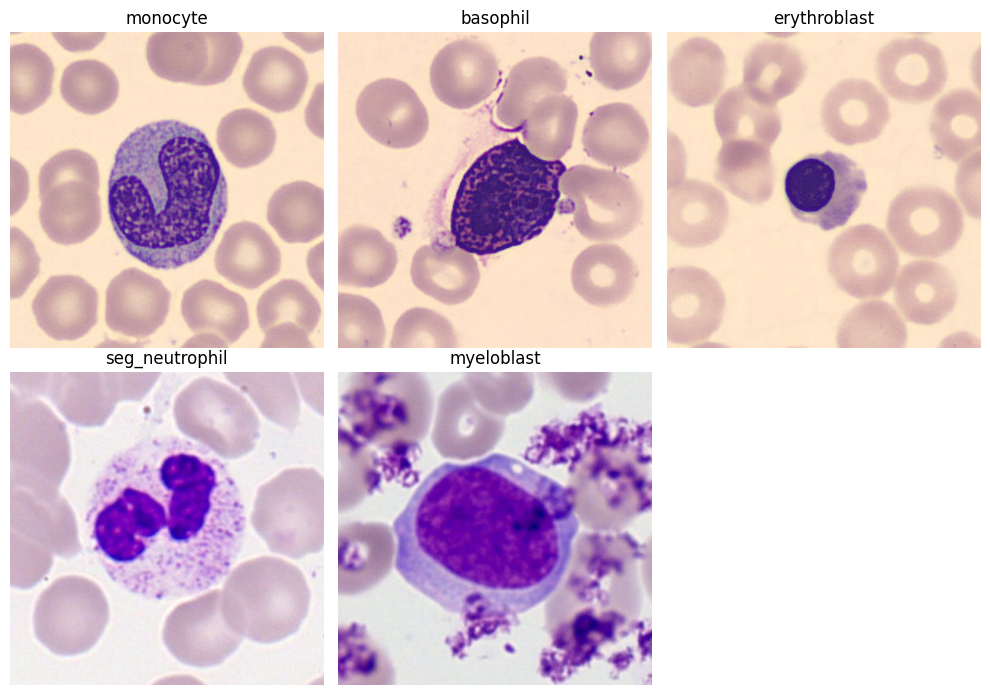

In [13]:
folder_path = sumithsingh_blood_cell_images_for_cancer_detection_path
class_folders = os.listdir(folder_path)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.ravel()

for i, cls in enumerate(class_folders[:5]):
    img_folder_path = os.path.join(folder_path, cls)
    image_name = os.listdir(img_folder_path)[0]
    img_path = os.path.join(img_folder_path, image_name)
    image = mpimg.imread(img_path)
    axes[i].imshow(image)
    axes[i].set_title(cls)
    axes[i].axis('off')

for j in range(i + 1, 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <h1 style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Data Preparation</span></b> </h1>

In [14]:
img_height, img_width = 224, 224
batch_size = 32
folder_path = sumithsingh_blood_cell_images_for_cancer_detection_path

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [15]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [16]:
model = Sequential()

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_tensor=Input(shape=(img_height, img_width, 3)),
                      pooling = 'avg',
                      classes = 5
                     )

for layer in base_model.layers:
    layer.trainable = False

model.add(base_model)
model.add(Dense(512, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

# <h1 style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Model Training</span></b> </h1>

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
print("--- Starting initial training phase ---")
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Use an Adam instance
    metrics=['accuracy']
)

# --- Callback function definitions ---
model_checkpoint = ModelCheckpoint(
    filepath='best_blood_cell_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    mode='min',
    verbose=1
)
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

# --- Train the model ---
epochs = 40
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

# --- Fine-tuning phase ---
print("\n--- Starting fine-tuning phase ---")

# 1. Load the best model saved during initial training
print("Loading the best model from the initial training phase: best_blood_cell_model.keras")
# Ensure the previous training actually saved the model, otherwise this will cause an error
try:
    model = tf.keras.models.load_model('best_blood_cell_model.keras')
except Exception as e:
    print(f"Failed to load model: {e}")
    print("Please ensure that the 'best_blood_cell_model.keras' file exists and is valid.")
    # May need to exit or handle the error
    exit() # Or raise e

# Get a reference to the base model (unchanged, but add a check)
try:
    base_model = model.layers[0]
    print(f"Getting the base model: {base_model.name}")
    # You can add a more specific check here, e.g.:
    # if not isinstance(base_model, tf.keras.applications.ResNet50):
    #     print(f"Warning: The first layer of the model '{base_model.name}' may not be the expected ResNet50 type.")
except IndexError:
    print("Error: Could not access the first layer of the model as the base model. Please check the model structure.")
    exit() # Or raise an exception

# ================== Modification Starts ==================

# 2. Set the entire base model as non-trainable
base_model.trainable = False
print(f"First, setting the entire base model '{base_model.name}' trainable = {base_model.trainable}")

# 3. *** Specify the name of the layer to start unfreezing from ***
#    You need to determine this name based on the structure of your base model (e.g., ResNet50).
#    Run base_model.summary() to see the list of layer names.
#    For example, 'conv5_block1_1_conv' for ResNet50 or 'block5_conv1' for VGG16
fine_tune_start_layer_name = 'conv5_block1_1_conv' # <<< --- Modify the desired layer name here ---
print(f"Planning to unfreeze from the base model layer '{fine_tune_start_layer_name}'...")

# 4. *** Set trainability based on layer name ***
#    Iterate through the base model's layers, find the layer with the specified name,
#    and set it and all subsequent layers to be trainable.
found_start_layer = False
print("Setting trainable = True for layers to be fine-tuned based on layer name...")
for layer in base_model.layers:
    if layer.name == fine_tune_start_layer_name:
        found_start_layer = True
        print(f"  -- Found starting layer: {layer.name} --")
    if found_start_layer:
        layer.trainable = True
        # print(f"  - Layer {layer.name} set to trainable") # You can uncomment to see which layers are unfrozen
    else:
        # Ensure layers before the starting layer remain non-trainable (although base_model.trainable = False already sets this, it's more explicit)
        layer.trainable = False

# 5. *** Add a check: Confirm if the specified layer name was found ***
if not found_start_layer:
    print(f"Warning: The specified layer name '{fine_tune_start_layer_name}' was not found in the base model '{base_model.name}'!")
    print("No base model layers will be unfrozen for fine-tuning. Please check if the layer name is correct.")
    # Depending on your needs, you can decide whether to exit, raise an error, or continue (only training the top layers)
    # exit() # For example, stop if the layer is not found

# ================== Modification Ends ==================

# 6. Check the number of trainable layers in the base model (logic unchanged, but now based on name lookup results)
trainable_layers_count_base = len([layer for layer in base_model.layers if layer.trainable])
print(f"Number of trainable layers in the base model ({base_model.name}): {trainable_layers_count_base}")
if trainable_layers_count_base == 0 and found_start_layer: # Only an error if the layer was found but the count is 0
    print("Error: Claimed to have found the starting layer, but the trainable layer count in the base model is 0! Please check the logic.")
elif trainable_layers_count_base == 0 and not found_start_layer:
    print("Hint: The base model remains fully frozen because the specified layer name was not found.")

# 7. Print the summary of the entire model (unchanged)
print("\nModel summary before compilation:")
model.summary()

# 8. Recompile the model with a very low learning rate (unchanged, but ensure Adam is imported)
fine_tune_lr = 1e-5 # <<< --- Recommended fine-tuning learning rate is 1e-5 or lower ---
print(f"\nRecompiling the model with fine-tuning learning rate: {fine_tune_lr}")
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), # Use an Adam instance
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 9. Continue training the model (unchanged, but pay attention to initial_epoch calculation)
fine_tune_epochs = 20
# Ensure the history object exists and contains epoch information
if 'history' in locals() and hasattr(history, 'epoch') and history.epoch:
    start_epoch_fine_tune = history.epoch[-1] + 1
else:
    print("Warning: Could not get epoch information from the 'history' object from the previous training. Fine-tuning epoch count will start from 0.")
    start_epoch_fine_tune = 0 # Or set to initial_epochs_completed (if you have that variable)

total_epochs_fine_tune = start_epoch_fine_tune + fine_tune_epochs

print(f"Continuing to train the model for fine-tuning, starting from Epoch {start_epoch_fine_tune}, training for up to {fine_tune_epochs} Epochs...")

# *** Note: Callback functions also need to be updated, especially the ModelCheckpoint file name, to avoid overwriting the initial model ***
fine_tune_checkpoint_filepath = 'best_fine_tuned_model.keras' # <<< --- New file name ---
fine_tune_checkpoint = ModelCheckpoint(
    filepath=fine_tune_checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# You can reuse early_stopping and reduce_lr, or create new instances for fine-tuning (e.g., with smaller patience)
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min', verbose=1) # Same as before
fine_tune_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, mode='min', verbose=1) # min_lr can be lower

callbacks_fine_tune_list = [fine_tune_checkpoint, fine_tune_early_stopping, fine_tune_reduce_lr]

history_fine = model.fit(
    train_generator,
    epochs=total_epochs_fine_tune,
    initial_epoch=start_epoch_fine_tune, # <--- Ensure training starts from the correct epoch
    validation_data=validation_generator,
    callbacks=callbacks_fine_tune_list # <--- Use the callback list prepared for fine-tuning
)

print("\nFine-tuning training complete.")
print(f"Best fine-tuned model saved at: {fine_tune_checkpoint_filepath}")

--- Starting initial training phase ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.2941 - loss: 1.5910
Epoch 1: val_accuracy improved from -inf to 0.49700, saving model to best_blood_cell_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - accuracy: 0.2946 - loss: 1.5902 - val_accuracy: 0.4970 - val_loss: 1.2835 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5396 - loss: 1.2404
Epoch 2: val_accuracy improved from 0.49700 to 0.56000, saving model to best_blood_cell_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.5396 - loss: 1.2400 - val_accuracy: 0.5600 - val_loss: 1.0874 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6291 - loss: 1.0301
Epoch 3: val_accuracy improved from 0.56000 to 0.75500, saving model to best_blood_cell_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 448ms/step - accuracy: 0.6291 - loss: 1.0299 - val_accuracy: 0.7550 - val_loss: 0.8310 - learning_rate: 0.0010
Epoch 4

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,742,673 (102.02 MB)

 Trainable params: 16,027,653 (61.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

 Optimizer params: 2,103,308 (8.02 MB)


Recompiling the model with fine-tuning learning rate: 1e-05
Continuing to train the model for fine-tuning, starting from Epoch 32, training for up to 20 Epochs...
Epoch 33/52
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5975 - loss: 15.7888
Epoch 33: val_accuracy improved from -inf to 0.22300, saving model to best_fine_tuned_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 510ms/step - accuracy: 0.5986 - loss: 15.6987 - val_accuracy: 0.2230 - val_loss: 38.0656 - learning_rate: 1.0000e-05
Epoch 34/52
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8575 - loss: 0.3865
Epoch 34: val_accuracy improved from 0.22300 to 0.31600, saving model to best_fine_tuned_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8575 - loss: 0.3866 - val_accuracy: 0.3160 - val_loss: 29.7024 - learning_rate: 1.0000e-05
Epoch 35/52
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8980 - loss: 0.2970
Epoch 35: val_accuracy improved from 0.31600 to 0.48600, saving model 

# <h1 style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Loss and Accuracy Visualization</span></b> </h1>

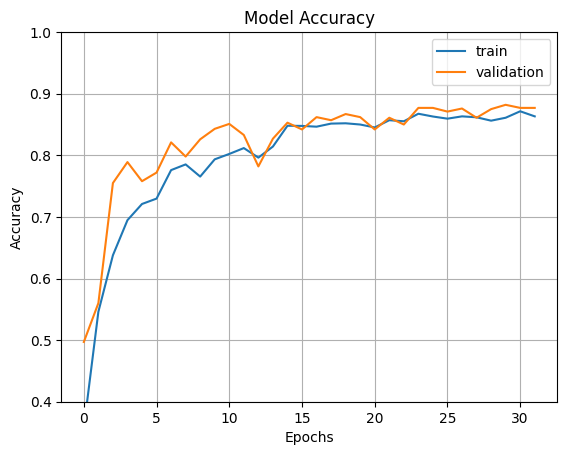

In [19]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

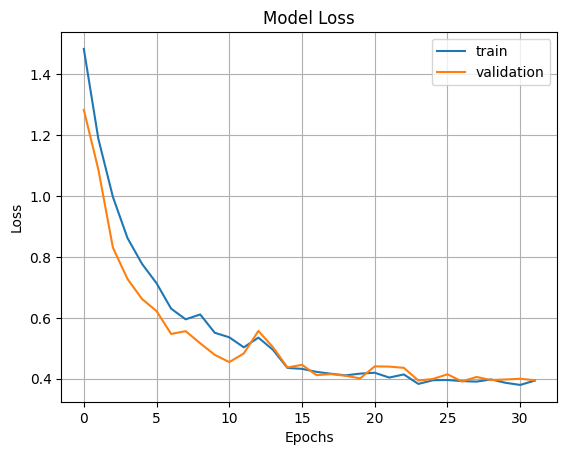

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# <h1 style="padding: 30px;color:white;margin:10;font-size:100%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Testing</span></b> </h1>

In [22]:
import os

test_img_path = os.path.join(sumithsingh_blood_cell_images_for_cancer_detection_path,'erythroblast/ERB_101031.jpg')
image = cv2.imread(test_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = image / 255.0
image = np.expand_dims(image, axis=0)

pred = model.predict(image)
output_class = class_names[np.argmax(pred)]
print("The predicted class is", output_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The predicted class is erythroblast
